In [35]:
import pandas as pd
import os
import sklearn
# for visualization
import matplotlib.pyplot as plt
import seaborn as sns
# for split data
from sklearn.model_selection import train_test_split
# for evaluation
from sklearn.metrics import confusion_matrix
# for lightgbm
import lightgbm as lgbm

In [36]:
df = pd.read_csv('dataset/Telecom_customer churn_10+1.csv')

# 1 | Understand and Preprocess the data

In [37]:
df.head()

,eqpdays,hnd_price,totmrc_Mean,mou_Mean,mou_cvce_Mean,avg3mou,models,avg3qty,uniqsubs,income,churn
0,361.0,149.98999,22.500,219.25,90.643333,272,2.0,116,2,4.0,1
1,240.0,NaN,37.425,482.75,189.396667,305,6.0,158,1,5.0,0
2,1504.0,29.98999,16.990,10.25,5.426667,12,1.0,7,1,5.0,1
3,1812.0,29.98999,38.000,7.50,8.410000,8,1.0,3,1,6.0,0
4,434.0,149.98999,71.980,570.50,285.233333,558,4.0,191,1,6.0,0


In [38]:
# 最初の10,000行を新たなDataFrameに定義
df = df.iloc[:10000]

# 確認
print(df)

      eqpdays   hnd_price  totmrc_Mean  mou_Mean  mou_cvce_Mean  avg3mou  \
0       361.0  149.989990       22.500    219.25      90.643333      272   
1       240.0         NaN       37.425    482.75     189.396667      305   
2      1504.0   29.989990       16.990     10.25       5.426667       12   
3      1812.0   29.989990       38.000      7.50       8.410000        8   
4       434.0  149.989990       71.980    570.50     285.233333      558   
...       ...         ...          ...       ...            ...      ...   
9995    163.0   79.989990       30.000    230.75       0.000000      232   
9996    979.0   59.989990       16.990      0.25       0.000000        0   
9997    477.0   29.989990      189.990   1662.00     974.063333     1547   
9998     76.0   99.989990       34.980    154.75      88.420000      204   
9999    822.0    9.989998       29.990    270.00     116.263333      227   

      models  avg3qty  uniqsubs  income  churn  
0        2.0      116         2     4.

In [39]:
df.shape

(10000, 11)

## Lets check for the Null value

**Lets replace null value in the residual dataframe with the average of each column.**

In [40]:
numeric_cols = df.select_dtypes(include='number').columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())

In [41]:
print(
    f"""
    The total number of null values left is
    {df.isna().sum().sum()}
    """
)


    The total number of null values left is
    0
    


**Lets see the distribution of churn customers**

([<matplotlib.patches.Wedge at 0x3174994e0>,
 [Text(-0.025915716606368096, 1.099694673822138, '0'),
  Text(0.025915716606367958, -1.099694673822138, '1')],
 [Text(-0.014135845421655323, 0.5998334584484389, '50.7%'),
  Text(0.014135845421655248, -0.5998334584484389, '49.3%')])

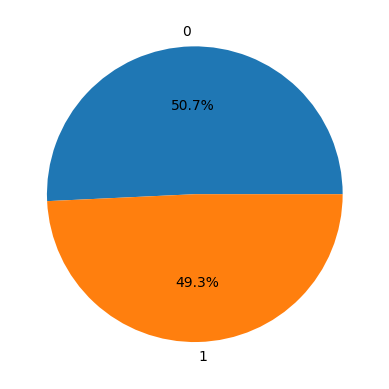

In [42]:
data = df.churn.value_counts()

plt.pie(
    data = data,
    x = data.values,
    labels = data.index,
    autopct='%1.1f%%'
)

> The target's distribution is quite unified

# 2 | LightGBM

In [43]:
X_train1, X_valid1, y_train1, y_valid1 = train_test_split(
      df.drop(labels=['churn'], axis=1),
      df['churn'],
      test_size=0.3,
      random_state=42)
X_train1.shape, X_valid1.shape, y_train1.shape, y_valid1.shape

((7000, 10), (3000, 10), (7000,), (3000,))

In [44]:
# Import metric for performance evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report,confusion_matrix, ConfusionMatrixDisplay

# Defining the modelling function
def modeling(X_train, X_valid, y_train, y_valid, alg, alg_name, params={}):
    model = alg(**params) # Instantiating the algorithm class and unpacking parameters if any
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    # Performance evaluation
    def print_scores(alg, y_true, y_pred):
        print(alg_name)
        acc_score = accuracy_score(y_true, y_pred)
        print("accuracy: ", f"{acc_score:.3f}")
        pre_score = precision_score(y_true, y_pred, average='binary')
        print("precision: ", f"{pre_score:.3f}")
        rec_score = recall_score(y_true, y_pred, average='binary')
        print("recall: ", f"{rec_score:.3f}")
        f_score = f1_score(y_true, y_pred, average="weighted")
        print("f1_score: ", f"{f_score:.3f}")
    print_scores(alg, y_valid, y_pred)
    
    # 訓練済みモデルから特徴量の重要度を取得
    # feature_importance = model.feature_importances_

    # feature importanceを表示
    importance = pd.DataFrame(model.feature_importances_, index=X_train.columns, columns=['importance'])
    display(importance)


    # print('Feature Importances:')
    # for i, feat in enumerate(X_train.columns):
    #     print('\t{0:20s} : {1:.1f}'.format(feat, feature_importance[i]))


    cm = confusion_matrix(y_valid, y_pred)
    # Create the confusion metrix display object (cmd_obj)
    cmd_obj = ConfusionMatrixDisplay(cm, display_labels=['churn', 'notChurn'])
    
    # The plot function for the sklearn visulaization
    cmd_obj.plot()
    
    # Use the Axes attribute 'ax_' to get to the underlying Axes object.
    # The Axes object controls the labels for the X and the Y axes. It also controls teh title.
    cmd_obj.ax_.set(
                    title = 'Sklearn Confusion Matrix with labels!!',
                    xlabel = 'Predicted Churn',
                    ylabel = 'Actual Churn'
    )
    # Finally, call the matplotlib show() function to display the visualization of the confusion matrix.
    plt.show()
    
    return model

[LightGBM] [Info] Number of positive: 3463, number of negative: 3537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1577
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494714 -> initscore=-0.021144
[LightGBM] [Info] Start training from score -0.021144
Light GBM
accuracy:  0.606
precision:  0.592
recall:  0.616
f1_score:  0.606


,importance
eqpdays,499
hnd_price,165
totmrc_Mean,408
mou_Mean,375
mou_cvce_Mean,406
avg3mou,343
models,108
avg3qty,436
uniqsubs,85
income,175


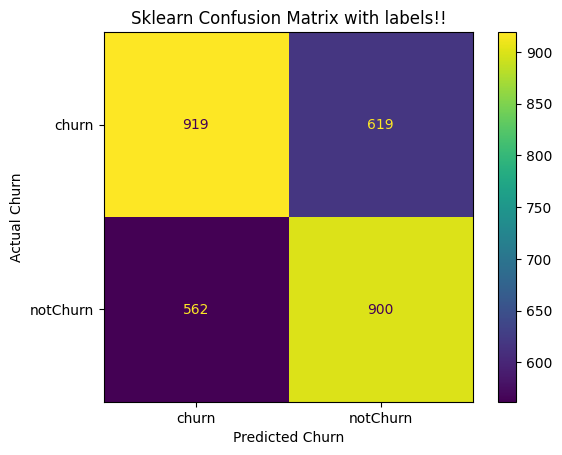

In [45]:
# LightGBM model
LGBM_model = modeling(X_train1, X_valid1, y_train1, y_valid1, lgbm.LGBMClassifier, 'Light GBM')

In [46]:
# RFE法で特徴量選択する
X_train1_2, X_valid1_2, y_train1_2, y_valid1_2 = train_test_split(
      df.drop(labels=['churn', 'uniqsubs'], axis=1),
      df['churn'],
      test_size=0.3,
      random_state=42)
X_train1_2.shape, X_valid1_2.shape, y_train1_2.shape, y_valid1_2.shape

((7000, 9), (3000, 9), (7000,), (3000,))

[LightGBM] [Info] Number of positive: 3463, number of negative: 3537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1568
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494714 -> initscore=-0.021144
[LightGBM] [Info] Start training from score -0.021144
Light GBM
accuracy:  0.607
precision:  0.592
recall:  0.622
f1_score:  0.607


,importance
eqpdays,524
hnd_price,151
totmrc_Mean,426
mou_Mean,418
mou_cvce_Mean,410
avg3mou,359
models,103
avg3qty,424
income,185


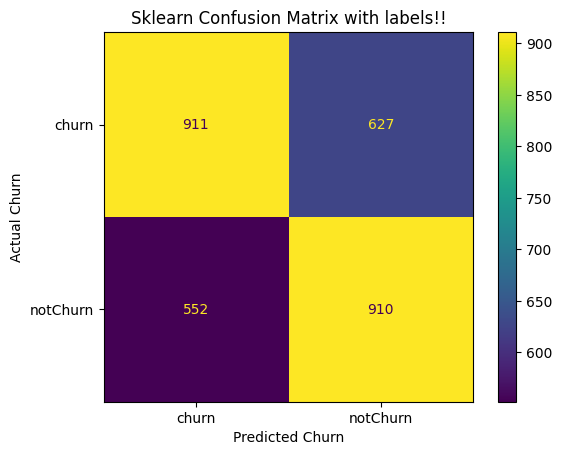

In [47]:
# LightGBM model
LGBM_model = modeling(X_train1_2, X_valid1_2, y_train1_2, y_valid1_2, lgbm.LGBMClassifier, 'Light GBM')

# 3 | Add Log likelihood as features

In [49]:
df_loglikelihood = pd.read_csv('dataset/loglikelihood_10000.csv')

# 横に結合
df_concat = pd.concat([df, df_loglikelihood], axis=1)

# 結果を確認
print(df_concat)

      eqpdays   hnd_price  totmrc_Mean  mou_Mean  mou_cvce_Mean  avg3mou  \
0       361.0  149.989990       22.500    219.25      90.643333      272   
1       240.0   79.714372       37.425    482.75     189.396667      305   
2      1504.0   29.989990       16.990     10.25       5.426667       12   
3      1812.0   29.989990       38.000      7.50       8.410000        8   
4       434.0  149.989990       71.980    570.50     285.233333      558   
...       ...         ...          ...       ...            ...      ...   
9995    163.0   79.989990       30.000    230.75       0.000000      232   
9996    979.0   59.989990       16.990      0.25       0.000000        0   
9997    477.0   29.989990      189.990   1662.00     974.063333     1547   
9998     76.0   99.989990       34.980    154.75      88.420000      204   
9999    822.0    9.989998       29.990    270.00     116.263333      227   

      models  avg3qty  uniqsubs    income  churn   ll_1A   ll_1B   ll_2A  \
0        2.

In [50]:
df_concat['ll_churn'] = (df_concat['ll_1A'] + df_concat['ll_2B'] / 2)
df_concat['ll_not_churn'] = (df_concat['ll_1B'] + df_concat['ll_2A'] / 2)

In [51]:
# 列Aと列B~Fの相関係数を計算
correlation = df_concat[['churn', 'eqpdays', 'hnd_price', 'totmrc_Mean', 'mou_Mean', 'mou_cvce_Mean', 'avg3mou', 'models', 'avg3qty', 'uniqsubs', 'income', 'll_churn', 'll_not_churn']].corr()

# 列Aとの相関だけを抽出
correlation_with_churn = correlation['churn'][1:]  # 列A自身の相関は除く

# 結果を表示
print(correlation_with_churn)

eqpdays          0.215503
hnd_price       -0.208130
totmrc_Mean     -0.120660
mou_Mean        -0.133146
mou_cvce_Mean   -0.117469
avg3mou         -0.122328
models          -0.123613
avg3qty         -0.106294
uniqsubs         0.016104
income           0.028069
ll_churn         0.066409
ll_not_churn    -0.064271
Name: churn, dtype: float64


In [52]:
X_train2, X_valid2, y_train2, y_valid2 = train_test_split(
      df_concat.drop(labels=['churn', 'll_1A', 'll_1B', 'll_2A', 'll_2B'], axis=1),
      df_concat['churn'],
      test_size=0.3,
      random_state=42)
X_train2.shape, X_valid2.shape, y_train2.shape, y_valid2.shape

((7000, 12), (3000, 12), (7000,), (3000,))

[LightGBM] [Info] Number of positive: 3463, number of negative: 3537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2087
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494714 -> initscore=-0.021144
[LightGBM] [Info] Start training from score -0.021144
Light GBM
accuracy:  0.600
precision:  0.584
recall:  0.622
f1_score:  0.600


,importance
eqpdays,414
hnd_price,141
totmrc_Mean,300
mou_Mean,297
mou_cvce_Mean,333
avg3mou,266
models,76
avg3qty,332
uniqsubs,64
income,112


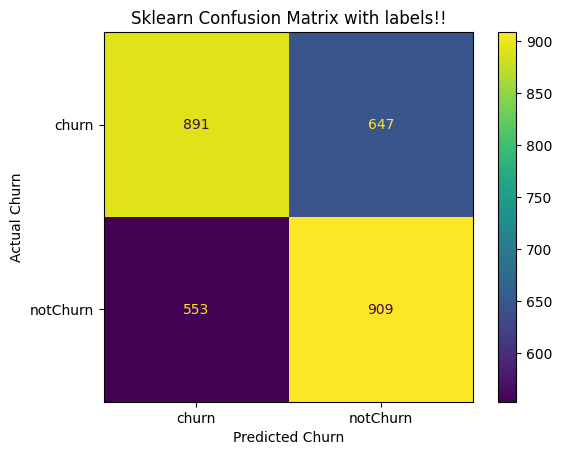

In [53]:
# LightGBM model
LGBM_model = modeling(X_train2, X_valid2, y_train2, y_valid2, lgbm.LGBMClassifier, 'Light GBM')

In [56]:
# RFE法で特徴量選択する
X_train2_2, X_valid2_2, y_train2_2, y_valid2_2 = train_test_split(
      df_concat.drop(labels=['churn', 'll_1A', 'll_1B', 'll_2A', 'll_2B', 'uniqsubs'], axis=1),
      df_concat['churn'],
      test_size=0.3,
      random_state=42)
X_train2_2.shape, X_valid2_2.shape, y_train2_2.shape, y_valid2_2.shape

((7000, 11), (3000, 11), (7000,), (3000,))

[LightGBM] [Info] Number of positive: 3463, number of negative: 3537
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2078
[LightGBM] [Info] Number of data points in the train set: 7000, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.494714 -> initscore=-0.021144
[LightGBM] [Info] Start training from score -0.021144
Light GBM
accuracy:  0.591
precision:  0.575
recall:  0.614
f1_score:  0.591


,importance
eqpdays,420
hnd_price,157
totmrc_Mean,321
mou_Mean,248
mou_cvce_Mean,335
avg3mou,246
models,93
avg3qty,351
income,97
ll_churn,345


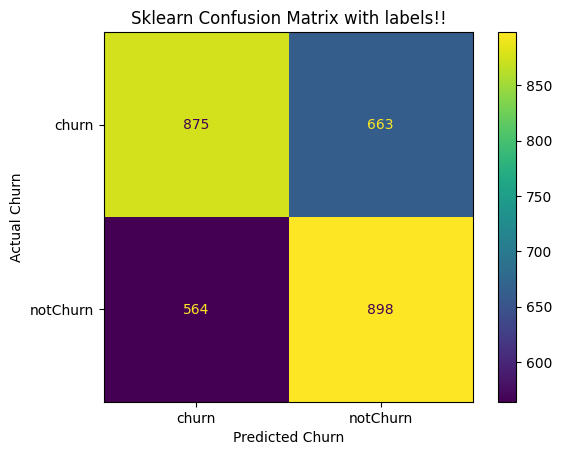

In [57]:
# LightGBM model
LGBM_model = modeling(X_train2_2, X_valid2_2, y_train2_2, y_valid2_2, lgbm.LGBMClassifier, 'Light GBM')